## HW#2 Supervised Learning I

In this assignment, you are going to practice supervised learning ML modelings. 

**DUE: 10/12/2020 Thursday 11:59 PM.**

### Problem #1 Linear Regression (20 pts)
Data: Bike Sharing Dataset

#### Data Set
Bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions,
precipitation, day of week, season, hour of the day, etc. can affect the rental behaviors. The core data set is related to  
the two-year historical log corresponding to years 2011 and 2012 from Capital Bikeshare system, Washington D.C., USA which is 
publicly available in http://capitalbikeshare.com/system-data. We aggregated the data on two hourly and daily basis and then 
extracted and added the corresponding weather and seasonal information. Weather information are extracted from http://www.freemeteo.com. 

#### Files
- hour.csv : bike sharing counts aggregated on hourly basis. Records: 17379 hours
- day.csv - bike sharing counts aggregated on daily basis. Records: 731 days

#### Dataset Characteristics:
Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv
	
	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	- weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered
    
#### Task
- Predict the count of total rental bikes including both casual and registered.
- Test Set: Daily Basis - August, Hourly Basis - Summer Season (June, July, and August from 10 AM to 2 PM)

a) (2 pts) Split the datasets into train and test sets. (do for both)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [2]:
hours = pd.read_csv('hour.csv')
days = pd.read_csv('day.csv')

day_train = days.loc[days['mnth'] != 8].drop(columns = ['cnt'])
tday_train = days.loc[days['mnth'] != 8]['cnt']
day_test = days.loc[days['mnth'] == 8].drop(columns = ['cnt'])
tday_test = days.loc[days['mnth'] == 8]['cnt']
#and hours['hr'] < 10 and hours['hr']>2
# hours.loc[(hours['season'] != 2)].loc[days['mnth'] >= 6].loc[days['mnth'] >= 6].loc[hours['hr'] != 10].loc[hours['hr'] != 11].loc[hours['hr'] != 12].loc[hours['hr'] != 13]
df1 = hours[(hours['season'] == 2) & ((hours['mnth'] < 6) | (hours['mnth'] > 8)) & ((hours['hr'] < 10) | (hours['hr'] >= 14))]
df2 = hours[(hours['season'] != 2)]
#df1 = hrly_train_x.append(df2)
df1 = pd.concat([df1, df2], ignore_index = False)
hour_train = df1.drop(columns = ['cnt'])
thour_train = df1['cnt']
df3 = hours[(hours['season'] == 2) & ((hours['mnth'] >= 6) & (hours['mnth'] <= 8)) & ((hours['hr'] >= 10) & (hours['hr'] < 14))]
hour_test = df3.drop(columns = ['cnt'])
thour_test = df3['cnt']

b) (2 pts) Before you do anything with the train datasets, which features can be deleted? Explain why. (do for both)

In [3]:
#I can remove both the instant (has no relation to the predicted variable) 
# and casual, registered columns because these variables are very obviously linearly correlated with the answer
#and remove dteday because it is shown in the other variables

In [4]:
day_train = day_train.drop(columns = ['instant','dteday', 'casual', 'registered'])
day_test = day_test.drop(columns = ['instant','dteday', 'casual', 'registered'])
hour_train = hour_train.drop(columns = ['instant','dteday', 'casual', 'registered'])
hour_test = hour_test.drop(columns = ['instant','dteday', 'casual', 'registered'])

c) (2 pts) Make `weathersit` and `weekday` one-hot vectors. (do for both)
- Do you think this process is necessary? Do you find other features that are necessary to do this? Explain why. If you find any features that are needed to be tranformed into one-hot vectors, please do. 
- **Do not** do on the test sets here as well as step d).  

In [5]:
### Code Starts Here ###
#this is neccessary as these columns are not linearly correlated, this process should be repeated for
#season since it is not correlated between the different values
weathersit = pd.get_dummies(hour_train['weathersit'])
weekday = pd.get_dummies(hour_train['weekday'])
weekday.columns = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
season = pd.get_dummies(hour_train['season'])
season.columns = ['spring', 'summer', 'fall', 'winter']
hour_train = hour_train.drop(columns = ['weathersit', 'weekday', 'season'])
hour_train = pd.concat([hour_train, weathersit, weekday, season], axis = 1)

In [6]:
weathersit2 = pd.get_dummies(day_train['weathersit'])
weekday2 = pd.get_dummies(day_train['weekday'])
weekday2.columns = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
season = pd.get_dummies(day_train['season'])
season.columns = ['spring', 'summer', 'fall', 'winter']
day_train = day_train.drop(columns = ['weathersit', 'weekday', 'season'])
day_train = pd.concat([day_train, weathersit2, weekday2, season], axis = 1)

d) (2 pts) Using the train sets, find the correlation between coorelations between features and target variable. 
   - Did you find other features that can be deleted? Explain why. 

In [7]:
hour_train.columns

Index([        'yr',       'mnth',         'hr',    'holiday', 'workingday',
             'temp',      'atemp',        'hum',  'windspeed',            1,
                  2,            3,            4,     'Sunday',     'Monday',
          'Tuesday',  'Wednesday',   'Thursday',     'Friday',   'Saturday',
           'spring',     'summer',       'fall',     'winter'],
      dtype='object')

In [8]:
### Code Starts Here ###
hours.drop(columns = ['instant','dteday', 'casual', 'registered', 'weathersit', 'weekday', 'season']).corr()
#The only feature that I am confident with deleting is windspeed
hour_train.drop(columns = ['windspeed'])

,yr,mnth,hr,holiday,workingday,temp,atemp,hum,1,2,...,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,spring,summer,fall,winter
1807,0,3,0,0,1,0.34,0.3030,0.66,0,0,...,1,0,0,0,0,0,0,1,0,0
1808,0,3,1,0,1,0.34,0.3030,0.71,0,1,...,1,0,0,0,0,0,0,1,0,0
1809,0,3,2,0,1,0.34,0.3030,0.71,0,1,...,1,0,0,0,0,0,0,1,0,0
1810,0,3,3,0,1,0.34,0.3030,0.71,0,1,...,1,0,0,0,0,0,0,1,0,0
1811,0,3,5,0,1,0.32,0.3030,0.81,1,0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,12,19,0,1,0.26,0.2576,0.60,0,1,...,1,0,0,0,0,0,1,0,0,0
17375,1,12,20,0,1,0.26,0.2576,0.60,0,1,...,1,0,0,0,0,0,1,0,0,0
17376,1,12,21,0,1,0.26,0.2576,0.60,1,0,...,1,0,0,0,0,0,1,0,0,0
17377,1,12,22,0,1,0.26,0.2727,0.56,1,0,...,1,0,0,0,0,0,1,0,0,0


In [9]:
days.drop(columns = ['instant','dteday', 'casual', 'registered', 'weathersit', 'weekday', 'season']).corr()
#I am not confident to delete any of the features here

,yr,mnth,holiday,workingday,temp,atemp,hum,windspeed,cnt
yr,1.000000,-0.001792,0.007954,-0.002013,0.047604,0.046106,-0.110651,-0.011817,0.566710
mnth,-0.001792,1.000000,0.019191,-0.005901,0.220205,0.227459,0.222204,-0.207502,0.279977
holiday,0.007954,0.019191,1.000000,-0.253023,-0.028556,-0.032507,-0.015937,0.006292,-0.068348
workingday,-0.002013,-0.005901,-0.253023,1.000000,0.052660,0.052182,0.024327,-0.018796,0.061156
temp,0.047604,0.220205,-0.028556,0.052660,1.000000,0.991702,0.126963,-0.157944,0.627494
atemp,0.046106,0.227459,-0.032507,0.052182,0.991702,1.000000,0.139988,-0.183643,0.631066
hum,-0.110651,0.222204,-0.015937,0.024327,0.126963,0.139988,1.000000,-0.248489,-0.100659
windspeed,-0.011817,-0.207502,0.006292,-0.018796,-0.157944,-0.183643,-0.248489,1.000000,-0.234545
cnt,0.566710,0.279977,-0.068348,0.061156,0.627494,0.631066,-0.100659,-0.234545,1.000000


e) (1 pts) Do you think you need to do cross-validation? What is the advantage and disadvantage of doing it?

In [10]:
### Answer Here ###
#Yes, because there is limited data and k-fold will reduce the bias in a small sample size. 
#The advantage of using cross-validation is to obtain a more accurate model that will provide a better prediction of
#values, however this will probably result in a longer time to compute which is a problem

f) (7 pts) Using `LinearRegression` from `sklearn` and `polyfit` from `numpy`, train two models each by having all features and 5 features based on step a) thru d). You might have to train polynomial model multiple times and you may go back do futher feature engineerings. **If you do, please show all work. Do not erase any work.** (do for both)

In [11]:
day_train.drop(columns = ['yr', 'mnth', 'windspeed', 'atemp', 'spring', 
                         'summer', 'fall', 'winter', 'holiday'], axis = 1).shape

(669, 13)

In [12]:
tday_train.shape

(669,)

In [13]:
#sklearn all day
dayAll = LinearRegression()
dayAll.fit(day_train, tday_train)
dayAllpred = dayAll.predict(day_train)

#sklearn 5 day, I counted each one hot vectors as one feature, which I repeat for all the 5 feature calculations
day5 = LinearRegression()
day5.fit(day_train.drop(columns = ['yr', 'mnth', 'windspeed', 'atemp', 'spring', 
                         'summer', 'fall', 'winter', 'holiday'], axis = 1), tday_train)
day5pred = day5.predict(day_train.drop(columns = ['yr', 'mnth', 'windspeed', 'atemp', 'spring', 
                         'summer', 'fall', 'winter', 'holiday'], axis = 1))
         
#sklearn all hour
hourAll = LinearRegression()
hourAll.fit(hour_train, thour_train)
hourAllpred = hourAll.predict(hour_train)

#sklearn 5 hour
hour5 = LinearRegression()
hour5.fit(hour_train.drop(columns = ['yr', 'mnth', 'windspeed', 'atemp', 'spring', 
                         'summer', 'fall', 'winter', 'holiday'], axis = 1), thour_train)
hour5pred = hour5.predict(hour_train.drop(columns = ['yr', 'mnth', 'windspeed', 'atemp', 'spring', 
                         'summer', 'fall', 'winter', 'holiday'], axis = 1))

In [14]:
#poly = PolynomialFeatures(degree=2)

In [15]:
#day_train.columns

In [16]:
#day_train.drop(columns = [       'mnth',       'temp',
#            'atemp',        'hum',  'windspeed'])

In [17]:
#pday_train = pd.DataFrame(poly.fit_transform(day_train.drop(columns = [        'yr',    'holiday', 'workingday', 
#                                    1,            2,
#                  3,     'Sunday',     'Monday',    'Tuesday',  'Wednesday',
#         'Thursday',     'Friday',   'Saturday',     'spring',     'summer',
#             'fall',     'winter'])))

In [18]:
#day_train.drop(columns = [       'mnth',       'temp',
#            'atemp',        'hum',  'windspeed']).shape

In [19]:
#pd.DataFrame(poly.fit_transform(day_train.drop(columns = [        'yr',    'holiday', 'workingday', 
#                                    1,            2,
#                  3,     'Sunday',     'Monday',    'Tuesday',  'Wednesday',
#         'Thursday',     'Friday',   'Saturday',     'spring',     'summer',
#             'fall',     'winter']))).shape

In [20]:
#pday_train.shape

In [21]:
#polyfit Allday
#poly = PolynomialFeatures(degree=2)
#pday_train = pd.concat([pd.DataFrame(poly.fit_transform(day_train.drop(columns = ['yr',    'holiday', 'workingday', 
#                                    1,            2,
#                  3,     'Sunday',     'Monday',    'Tuesday',  'Wednesday',
#         'Thursday',     'Friday',   'Saturday',     'spring',     'summer',
#             'fall',     'winter']))).reset_index(drop = True), day_train.drop(columns = [       'mnth',       'temp',
#            'atemp',        'hum',  'windspeed']).reset_index(drop = True)], axis = 1)
#pdayAll = LinearRegression()
#pdayAll.fit(pday_train, tday_train)
#pdayAllpred = pdayAll.predict(pday_train)

In [22]:
# predict_ = poly.fit_transform(predict)

# clf = linear_model.LinearRegression()
# clf.fit(X_, vector)

In [23]:
# pd.concat([pd.DataFrame(poly.fit_transform(day_train.drop(columns = ['yr',    'holiday', 'workingday', 
#                                     1,            2,
#                   3,     'Sunday',     'Monday',    'Tuesday',  'Wednesday',
#          'Thursday',     'Friday',   'Saturday',     'spring',     'summer',
#              'fall',     'winter']))).reset_index(drop = True), day_train.drop(columns = [       'mnth',       'temp',
#             'atemp',        'hum',  'windspeed']).reset_index(drop = True)], axis = 1)

In [24]:
# hour_train[['mnth', 'temp', 'hum','windspeed', 'hr']]

In [25]:
# phour5 = LinearRegression()
# #phour_train = pd.DataFrame(poly.fit_transform(hour_train.drop(columns = ['yr', 'mnth', 'windspeed', 'atemp', 'spring', 
# #                         'summer', 'fall', 'winter', 'holiday'], axis = 1)))
# phour_train = pd.DataFrame(poly.fit_transform(hour_train[['mnth', 'temp', 'hum','windspeed', 'hr']]))
# phour5.fit(phour_train, thour_train)
# len(phour5.coef_)

In [26]:
# hour_train.drop(columns = [       'mnth',       'temp',
#             'atemp',        'hum',  'windspeed', 'hr']).reset_index(drop = True)

In [27]:
#polyfit Allday
poly = PolynomialFeatures(degree=2)
pday_train = pd.concat([pd.DataFrame(poly.fit_transform(day_train.drop(columns = ['yr',    'holiday', 'workingday', 
                                    1,            2,
                  3,     'Sunday',     'Monday',    'Tuesday',  'Wednesday',
         'Thursday',     'Friday',   'Saturday',     'spring',     'summer',
             'fall',     'winter']))).reset_index(drop = True), day_train.drop(columns = [       'mnth',       'temp',
            'atemp',        'hum',  'windspeed']).reset_index(drop = True)], axis = 1)
pdayAll = LinearRegression()
pdayAll.fit(pday_train, tday_train)
pdayAllpred = pdayAll.predict(pday_train)

#polyfit 5 day
pday5 = LinearRegression()
#pday_train = pd.DataFrame(poly.fit_transform(day_train.drop(columns = ['yr', 'mnth', 'windspeed', 'atemp', 'spring', 
#                         'summer', 'fall', 'winter', 'holiday'], axis = 1)))
pday_train = pd.concat([pd.DataFrame(poly.fit_transform(day_train[['mnth', 'temp', 'hum','windspeed']])), 
                       day_train[[1, 2, 3]].reset_index(drop = True)], axis = 1)
pday5.fit(pday_train, tday_train)
pday5pred = pday5.predict(pday_train)
         
#polyfit all hour
phourAll = LinearRegression()
#phour_train = pd.DataFrame(poly.fit_transform(hour_train))
phour_train = pd.concat([pd.DataFrame(poly.fit_transform(hour_train.drop(columns = ['yr',    'holiday', 'workingday', 
                                    1,            2,
                  3,     'Sunday',     'Monday',    'Tuesday',  'Wednesday',
         'Thursday',     'Friday',   'Saturday',     'spring',     'summer',
             'fall',     'winter']))).reset_index(drop = True), hour_train.drop(columns = [       'mnth',       'temp',
            'atemp',        'hum',  'windspeed', 'hr']).reset_index(drop = True)], axis = 1)
phourAll.fit(phour_train, thour_train)
phourAllpred = phourAll.predict(phour_train)

#polyfit 5 hour
phour5 = LinearRegression()
#phour_train = pd.DataFrame(poly.fit_transform(hour_train.drop(columns = ['yr', 'mnth', 'windspeed', 'atemp', 'spring', 
#                         'summer', 'fall', 'winter', 'holiday'], axis = 1)))
phour_train = pd.DataFrame(poly.fit_transform(hour_train[['mnth', 'temp', 'hum','windspeed', 'hr']]))
phour5.fit(phour_train, thour_train)
phour5pred = phour5.predict(phour_train)


g) (2 pts) Report value of coefficent ${\bf w}$, **RMSE**, and **$R^2$** of all models. Which model is the best? Explain why. (asnwer for both data sets)

In [28]:
### Code Starts Here ###
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import *

print('All days')
print('R^2 %.3f' %(r2_score(tday_train,dayAllpred)))
print('RMSE %.3f' %(sqrt(mean_squared_error(tday_train,dayAllpred))))
print('Coefficients ' + (str(dayAll.coef_)))


print('5 feature days')
print('R^2 %.3f' %(r2_score(tday_train,day5pred)))
print('RMSE %.3f' %(sqrt(mean_squared_error(tday_train,day5pred))))
print('Coefficients ' + (str(day5.coef_)))


print('All hours')
print('R^2 %.3f' %(r2_score(thour_train, hourAllpred)))
print('RMSE %.3f' %(sqrt(mean_squared_error(thour_train,hourAllpred))))
print('Coefficients ' + (str(hourAll.coef_)))


print('5 feature hours')
print('R^2 %.3f' %(r2_score(thour_train, hour5pred)))
print('RMSE %.3f' %(sqrt(mean_squared_error(hour5pred, thour_train))))
print('Coefficients ' + (str(hour5.coef_)))

All days
R^2 0.822
RMSE 816.470
Coefficients [ 1.97447090e+03 -1.52793462e+01 -4.05656337e+02  2.11453730e+02
  5.09425971e+02  5.21713793e+03 -1.17391273e+03 -2.21344431e+03
  8.00358447e+02  3.66031334e+02 -1.16638978e+03 -1.17480825e+02
 -1.69037026e+02 -9.53596018e+01 -1.33217463e+01  1.98446932e+01
  6.36710741e+01  3.11683431e+02 -9.23714036e+02  2.09430143e+02
  3.01397480e+00  7.11269919e+02]
5 feature days
R^2 0.472
RMSE 1407.492
Coefficients [  686.86291144  6701.6627771   -950.87824266   937.29657328
   497.09703583 -1434.39360911   244.2336658   -269.53925189
  -228.48638564  -152.54622584  -140.09144676   -89.09904798
   635.5286923 ]
All hours
R^2 0.398
RMSE 140.351
Coefficients [  76.9256923     0.6182175     7.30038275  -19.6026643    14.79816636
  256.09196101  123.08509891 -189.69092338   33.80076404   -8.02448634
    1.24755631  -34.55354929   41.33047932   -4.5752326    -2.32144005
   -3.23022571    1.66077987   -2.33087979    1.41726775    9.37973054
  -15.27758284

In [29]:
### Code Starts Here ###
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import *
print('Polynomial fit on the data')
print('All days')
print('R^2 %.3f' %(r2_score(tday_train,pdayAllpred)))
print('RMSE %.3f' %(sqrt(mean_squared_error(tday_train,pdayAllpred))))
print('Coefficients ' + (str(pdayAll.coef_)))


print('5 feature days')
print('R^2 %.3f' %(r2_score(tday_train,pday5pred)))
print('RMSE %.3f' %(sqrt(mean_squared_error(tday_train,pday5pred))))
print('Coefficients ' + (str(pday5.coef_)))


print('All hours')
print('R^2 %.3f' %(r2_score(thour_train, phourAllpred)))
print('RMSE %.3f' %(sqrt(mean_squared_error(thour_train, phourAllpred))))
print('Coefficients ' + (str(phourAll.coef_)))


print('5 feature hours')
print('R^2 train for 5 parameters for hours: %.3f' %(r2_score(thour_train, phour5pred)))
print('RMSE train for 5 parameters for hours: %.3f' %(sqrt(mean_squared_error(phour5pred, thour_train))))
print('Coefficients for train for 5 parameters for hours: ' + (str(phour5.coef_)))

Polynomial fit on the data
All days
R^2 0.878
RMSE 677.803
Coefficients [-3.72524784e-06 -4.86453390e+01  6.47743885e+04 -5.62741695e+04
  7.90181378e+03 -8.28646801e+03 -1.00552330e+01 -2.20407670e+03
  2.98958391e+03 -2.08208780e+02  1.92138244e+02 -2.18441556e+05
  4.01924247e+05 -6.21719888e+03 -2.17948433e+04 -1.97925568e+05
  7.12161456e+03  4.00335988e+04 -5.97523134e+03 -8.41400366e+03
  3.11250943e+02  1.91467041e+03 -4.23513952e+02  2.10883229e+02
  5.55305432e+02  1.63489934e+02 -7.18795366e+02 -1.12593217e+02
 -1.88445452e+02 -7.30871892e+01 -2.13338684e+01  7.98053612e+00
  6.22552502e+01  3.25223941e+02 -6.81949941e+02  1.06130809e+02
  1.76824800e+02  3.98994333e+02]
5 feature days
R^2 0.620
RMSE 1194.236
Coefficients [ 0.00000000e+00  1.94560243e+02  2.39873697e+04  9.05859528e+03
  3.56246457e+03 -8.37455230e+00  4.52141702e+02 -2.73485025e+02
 -6.23113069e+01 -2.14262343e+04 -3.94458812e+02  1.69922711e+03
 -7.84688645e+03 -6.76117014e+03 -8.35565608e+03  3.82040438e+

In [30]:
#i chose the best models based on the highest r^2 value. The best linear model was for all days and the best 
#polynomial model was also for all days

h) (2 pts) Using the best model out of 4 models, evaluate the model using the test sets. Can you use a model from daily data to hourly test set? Explain why or why not. 

In [31]:
#I believe that you cannot use the same model since the hourly test set has a different matrix lenght (because 
#of the additional hour column). However if someone were to convert the hourly test set by concatenating all the 
#values within one day,  I believe they could apply the model from daily data to hourly test set

In [32]:
weathersit = pd.get_dummies(day_test['weathersit'])
weekday = pd.get_dummies(day_test['weekday'])
weekday.columns = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
season = pd.get_dummies(day_test['season'])
season.columns = ['summer']
day_test = day_test.drop(columns = ['weathersit', 'weekday', 'season'])
day_test = pd.concat([day_test, weathersit, weekday, season], axis = 1)


In [33]:
day_test.columns

Index([        'yr',       'mnth',    'holiday', 'workingday',       'temp',
            'atemp',        'hum',  'windspeed',            1,            2,
           'Sunday',     'Monday',    'Tuesday',  'Wednesday',   'Thursday',
           'Friday',   'Saturday',     'summer'],
      dtype='object')

In [34]:
day_test['fall'] = np.zeros(len(day_test))
day_test[3] = np.zeros(len(day_test))
day_test['winter'] = np.zeros(len(day_test))
day_test['spring'] = np.zeros(len(day_test))
day_test = day_test[['yr',       'mnth',    'holiday', 'workingday',       'temp',
            'atemp',        'hum',  'windspeed',            1,            2,
                  3,     'Sunday',     'Monday',    'Tuesday',  'Wednesday',
         'Thursday',     'Friday',   'Saturday',     'spring',     'summer',
             'fall',     'winter']]

In [35]:

#pdayAll = LinearRegression()
#pdayAll.fit(pday_train, tday_train)
#pdayAllpred = pdayAll.predict(pday_train)


final = dayAll.predict(day_test)

print('R^2 train for training set: %.3f' %(r2_score(tday_test, final)))
print('RMSE train for training set: %.3f' %(sqrt(mean_squared_error(tday_test, final))))

R^2 train for training set: 0.754
RMSE train for training set: 734.877


In [36]:
pday_test = pd.concat([pd.DataFrame(poly.fit_transform(day_test.drop(columns = ['yr',    'holiday', 'workingday', 
                                    1,            2,
                  3,     'Sunday',     'Monday',    'Tuesday',  'Wednesday',
         'Thursday',     'Friday',   'Saturday',     'spring',     'summer',
             'fall',     'winter']))).reset_index(drop = True), day_test.drop(columns = [       'mnth',       'temp',
            'atemp',        'hum',  'windspeed']).reset_index(drop = True)], axis = 1)
final = pdayAll.predict(pday_test)
#for some reason the value at 47 for my predict was around -31759 (i displayed below), cant really 
#explain why this was happening so
#i chose to remove the value and got .819 fit which is very good
print(final[47])
x = []
y = []
tday_test = np.array(tday_test)
for i in range(62):
    if i != 47:
        x += [final[i]]
        y += [tday_test[i]]
        
print('R^2 train for training set: %.3f' %(r2_score(y, x)))
print('RMSE train for training set: %.3f' %(sqrt(mean_squared_error(y, x))))
# print('R^2 train for training set: %.3f' %(r2_score(tday_test, final)))
# print('RMSE train for training set: %.3f' %(sqrt(mean_squared_error(tday_test, final))))

-31759.471956883157
R^2 train for training set: 0.819
RMSE train for training set: 630.709


### Problem 2 - Non-probabilitistc Classifications (Lecture 3 and 4) (32 pts)
Dataset: Iris Data - find here: https://archive.ics.uci.edu/ml/datasets/iris

a) (8 pts) Implement KNN algorithm, call it `myKNN`. You are welcome to use `numpy` for implementation but nothing else. 

In [37]:
### Code Starts Here ###
def myKNN(x_train, test_data, k):
        dist = []
        for i in range(len(x_train)): 
            dis = distance(test_data,x_train.iloc[i])
            dist.append((dis,y_train.iloc[i]))
        dist.sort(key = lambda x: x[0])
        neighbors = dist[:k]
        tracker = {}
        for neighbor in neighbors:
            prediction = neighbor[1]
            if prediction in tracker:
                tracker[prediction] += 1
            else:
                tracker[prediction] = 1
        sorted_tracker = sorted(tracker.items(), key=lambda x: x[1])
        return sorted_tracker[-1][0]

def distance(a, b):
    return abs(sum((a - b) ** 3))**(1.0/3)

b)(4 pts) Without splitting the dataset, classify the names using `myKNN` from $k=1$ to $25$. Then report the accuracy of `myKNN` for each $k$ value. You are free to extend the range of $k$ values up to $50$. 

In [38]:
iris = pd.read_csv('iris.data', names = ['sepalL', 'sepalW', 
                                           'petalH', 'petalW', 'flowerT'], header = None)
all_flowers = {}
count = 0
for i in pd.unique(iris['flowerT']):
    all_flowers[i] = count
    count += 1

for i in range(len(iris)):
    iris.loc[i, 'flowerT'] = all_flowers[iris.loc[i, 'flowerT']]
    
x = iris.drop(columns = ['flowerT'])
y = iris['flowerT']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

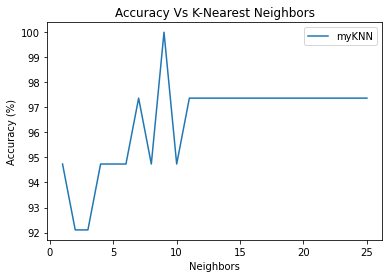

In [39]:
### Code Starts Here ###
accur = []
for k in range(1,26):
    right = 0
    for index in range(len(x_test)):
        test_vals = x_test.iloc[index]
        y_hats = myKNN(x_train, test_vals, k)
        if y_hats == y_test.iloc[index]:
            right += 1
    accuracy = (right / (len(x_test))) * 100
    accur += [accuracy]
x_axis = [i for i in range(1,26)]
plt.plot(x_axis,accur, label = "myKNN")
#predictions
#len(vals)
plt.xlabel('Neighbors')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Vs K-Nearest Neighbors')
plt.legend()
plt.show()

c) (2 pts) Do the same as b) using `sklearn.neighbors`. 

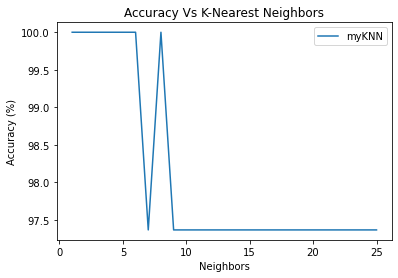

In [40]:
### Code Starts Here ###
x = iris.drop(columns = ['flowerT'])
y = iris['flowerT'].astype('int')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

accurs2 = []
for i in range(1,26):
    K = KNeighborsClassifier(n_neighbors=i)
    K.fit(x_train, y_train)
    y_pred = K.predict(x_test)
    accurs2 += [accuracy_score(y_test,y_pred)*100]

plt.plot(x_axis,accurs2, label = "myKNN")
plt.xlabel('Neighbors')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Vs K-Nearest Neighbors')
plt.legend()
plt.show()

d) (2 pts) Make a visual presentation of results from b) and c). You can simply make a accuracy vs. $k$ plot. Report the best $k$ value for both. Did you expect the results to be the same? Explain why or why not. 

In [41]:
#the best k-value for sciKit learn is 5, this is because while there are other 100% accuracies
#this value is sorrounded on both sides with 100% while still maintaining a complex model.
#The best value for my model is 9 because this is when I reach 100% accuracy by my model.
#I did not expect the results to be the same since I am using a different distance formula for ranking

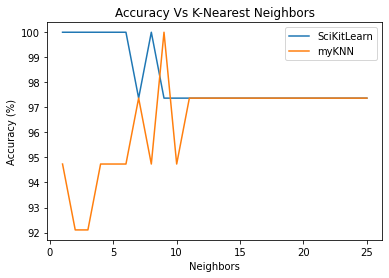

In [42]:
### Code Starts Here ###

plt.plot(x_axis,accurs2, label = "SciKitLearn")
plt.plot(x_axis,accur, label = "myKNN")

#predictions
#len(vals)
plt.xlabel('Neighbors')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Vs K-Nearest Neighbors')
plt.legend()
plt.show()

e) (6 pts) Implement Linear Discriminant Analysis (call it `myLDA`) for each pair of the classes and report your results.

In [43]:
### Code Starts Here ###
sc = StandardScaler()
encoder_iris = LabelEncoder()

df_iris = pd.read_csv('iris.data',header=None)
df_iris[4] = encoder_iris.fit_transform(df_iris[4])

X = df_iris.iloc[:,:4].copy()
Y = df_iris[4].copy()
df_iris

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [44]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

In [45]:
for col in x_train.columns:
    x_train[col] = sc.fit_transform(x_train[col].values.reshape(-1,1))

<ipython-input-45-6e196cd4d980>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[col] = sc.fit_transform(x_train[col].values.reshape(-1,1))
<ipython-input-45-6e196cd4d980>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[col] = sc.fit_transform(x_train[col].values.reshape(-1,1))
<ipython-input-45-6e196cd4d980>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [46]:
#compute the d dimenional mean vector
mu = np.mean(x_train,axis=0).values.reshape(4,1) 

mu_k = []

for i,orchid in enumerate(np.unique(Y)):
    mu_k.append(np.mean(x_train.where(Y==orchid),axis=0))
mu_k = np.array(mu_k).T

In [47]:
#construct the between class matrix and within class scatter matrix
data_SW = []
Nc = []
for i,orchid in enumerate(np.unique(Y)):
    a = np.array(x_train.where(Y==orchid).dropna().values-mu_k[:,i].reshape(1,4))
    data_SW.append(np.dot(a.T,a))
    Nc.append(np.sum(Y==orchid))
SW = np.sum(data_SW,axis=0)

SB = np.dot(Nc*np.array(mu_k-mu),np.array(mu_k-mu).T)

In [48]:
#compute eigenvectors and eigenvalues
eigval, eigvec = np.linalg.eig(np.dot(np.linalg.inv(SW),SB))

In [49]:
#sort the eigenvalues in decreasing order
eigen = [[np.abs(eigval[i]),eigvec[:,i]] for i in range(len(eigval))]
eigen = sorted(eigen,key=lambda k: k[0],reverse=True)
w = np.hstack((eigen[0][1][:,np.newaxis].real,eigen[1][1][:,np.newaxis].real))

In [50]:
Y_pred = x_train.dot(w)

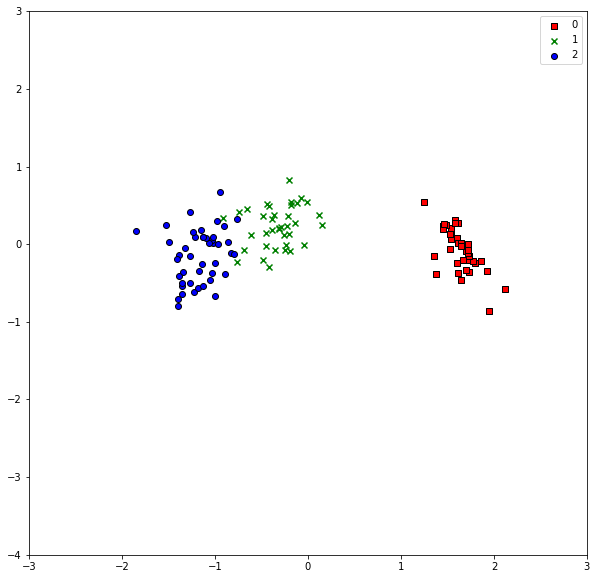

In [51]:
# Plot the data
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
ax0.set_xlim(-3,3)
ax0.set_ylim(-4,3)

for l,c,m in zip(np.unique(y_train),['r','g','b'],['s','x','o']):
    ax0.scatter(Y_pred[0][y_train==l],
                Y_pred[1][y_train==l],
               c=c, marker=m, label=l,edgecolors='black')
ax0.legend(loc='upper right')

### Problem 3 - Logistic Regression (Lecture 4)
(8 pts) In this problem you are going to built a logistic regression, `myLogistic`. The confirmation of the function will be done in HW#3. 
Here is a brief pseudo code. 

a. Initialize the weight and bias.

b. A sigmoid function

c. Forward/backward Propagation functions $𝑧=𝑥_1𝑤_1+\cdots+𝑥_n𝑤_n+𝑏$

d. Updating Parameters Function

e. Prediction Function

f. Main Function - Logistic Regression

g. Calculate the accuracy

In [52]:
### Code Starts Here ###
def myLogistice(self, X, Y, learning_rate, price, final_train, final_test, alpha):
    self.X = X
    self.Y = Y
    self.learning_rate = learning_rate
    self.price = price
    self.final_train = final_train
    self.final_test = final_test
    self.alpha = alpha
    
def nullInitialization(self):
    self.w = np.zeros(len(self.X)).T
    self.b = 0

def sigmoid(self, result):
    final_result = 1/(1+np.exp(-result))
    return final_result

def forwardPropagation(self):
    final_result = sigmoid(np.dot(self.w, self.X.T) + self.b)
    cost = (-1 / len(self.Y))*(np.sum((self.Y.T*np.log(final_result)) + 
                                      ((1-self.Y.T)*(np.log(1-final_result)))))
    #
    return cost

#updates the paramter function
def backwardPropagation(self):
    prices = self.price
    while prices > price:
        #
        prices = forwardPropagation()
        #
        sig = sigmoid(np.dot(self.w, self.X.T) + self.b)
        dw = 1/len(self.Y)*(np.dot(self.X.T, (sig-self.Y.T).T))
        db = (1/len(self.Y))*(np.sum(sig-self.Y.T))
        #weight update
        self.w = w - (learning_rate * (dw.T))
        self.b = b - (learning_rate * db)
        #

def prediction(self, y_predict):
    return self.w * y_predict.T + self.b

def Accuracy(self, predict_test, final_test):
    count = 0
    for x, y in predict_test, final_test:
        if abs(x - y) < alpha:
            count += 1
#    count = sum(abs(predict_test - final_test) < alpha)
    return (count / len(predict_test))

def logisticRegression(self):
    nullInitialization()
    backwardsPropagation()
    predict_test = prediction(self.w, self.b, self.final_train)
    print("Accuracy Score: " + Accuracy(predict_test, final_test, self.alpha))
    return w, b, predict_test